In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import requests
import urllib
from sklearn.model_selection import train_test_split

# California Wildfires 1992-2018

Nathaniel Mutkus

__Problem:__

Wildfires pose a threat to human life, wildlife, and property.  My goal will be to perform a regression analysis of the data to determine if the size and/or frequency of fires is increasing in California as a whole or specific areas.  I would also like to determine if specific causes of wildfires (i.e. utilities, arson, lightning, etc.) are more common at specific times of the year and if they correlate to the resulting sizes of fires, and thus may be preventable through policy changes by the government.

__Data Source:__

The United States Department of Agriculture website provides a wildfire dataset spanning the period from 1992 to 2018 that is a compilation of reports from various local, state, and federal agencies with over 2 million entries.\
This dataset is avaliable online from various other governemnt agencies, but the USDA provides a more convenient file format than some others (I chose their SQLite database).\

Short, Karen C. 2021. Spatial wildfire occurrence data for the United States, 1992-2018 [FPA_FOD_20210617]. 5th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.5

https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.5

The database includes two tables, 'Fires' and 'NWCG_UnitIDActive_20200123', the latter of which provides information about the various agencies involved in reporting wildfire data.  For my purposes, I will only be using the 'Fires' table.\
The 'Fires' table contains 37 attributes, which include the fire name, size, reporting agency, fire code, date of discovery, date of containment, cause, and location.  These will be discussed in more detail in the next section.

__Data Cleaning:__

To make the file size manageable within the limitation of the CSEL machine and a pandas dataframe, I used SQLiteStudio (v3.3.3) to export only the data for California from the 'Fires' table to a CSV file with UTF-8 encoding using the export feature with the following query:
<center> SELECT * FROM Fires WHERE STATE = 'CA'

From the CSV file, the data can be read into a pandas dataframe:

In [2]:
fires = pd.read_csv('CA_fires.csv')
fires

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,11,14,25,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1.0,...,1730.0,0.10,A,40.036944,-121.005833,USFS,CA,63.0,6063.0,Plumas County
1,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13.0,...,1530.0,0.25,A,38.933056,-120.404444,USFS,CA,61.0,6061.0,Placer County
2,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27.0,...,2024.0,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17.0,6017.0,El Dorado County
3,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43.0,...,1400.0,0.10,A,38.559167,-119.913333,USFS,CA,3.0,6003.0,Alpine County
4,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44.0,...,1200.0,0.10,A,38.559167,-119.933056,USFS,CA,3.0,6003.0,Alpine County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235224,400482013,ICS209_2017_7211175,INTERAGCY,IA-ICS209,DOD,USCAFHL,Fort Hunter Liggett,CAFHL,Hunter Liggett Military Reservation,NaN,...,NaN,1200.00,F,35.957900,-121.270100,OTHER FEDERAL,CA,Monterey,6053.0,Monterey County
235225,400482017,ICS209_2017_7334767,INTERAGCY,IA-ICS209,ST/C&L,USCANEU,Nevada-Yuba-Placer Unit,CANEU,Nevada-Yuba-Placer Unit,NaN,...,NaN,950.00,E,39.120278,-121.318889,MISSING/NOT SPECIFIED,CA,Yuba,6115.0,Yuba County
235226,400482049,ICS209_2015_2815337,INTERAGCY,IA-ICS209,ST/C&L,USCAKRN,Kern County Fire Department,CAKRN,Kern County Fire Department,NaN,...,NaN,224.00,D,35.811944,-118.794167,STATE OR PRIVATE,CA,Kern,6029.0,Kern County
235227,400482065,ICS209_2015_2736428,INTERAGCY,IA-ICS209,ST/C&L,USCAVNC,Ventura County Fire Department,CAVNC,Ventura County Fire Department,NaN,...,NaN,164.00,D,34.342500,-119.065833,COUNTY,CA,Ventura,6111.0,Ventura County


In [3]:
fires.dtypes

FOD_ID                             int64
FPA_ID                            object
SOURCE_SYSTEM_TYPE                object
SOURCE_SYSTEM                     object
NWCG_REPORTING_AGENCY             object
NWCG_REPORTING_UNIT_ID            object
NWCG_REPORTING_UNIT_NAME          object
SOURCE_REPORTING_UNIT             object
SOURCE_REPORTING_UNIT_NAME        object
LOCAL_FIRE_REPORT_ID             float64
LOCAL_INCIDENT_ID                 object
FIRE_CODE                         object
FIRE_NAME                         object
ICS_209_PLUS_INCIDENT_JOIN_ID     object
ICS_209_PLUS_COMPLEX_JOIN_ID      object
MTBS_ID                           object
MTBS_FIRE_NAME                    object
COMPLEX_NAME                      object
FIRE_YEAR                          int64
DISCOVERY_DATE                    object
DISCOVERY_DOY                      int64
DISCOVERY_TIME                   float64
NWCG_CAUSE_CLASSIFICATION         object
NWCG_GENERAL_CAUSE                object
NWCG_CAUSE_AGE_C

\
\
There are 235,229 individual rows, each representing a separate wildfire.

Before dealing with the warning given above about five of the columns having mixed data types (mostly due to NaNs), we can eliminate several of the columns from the dataframe.

FOD_ID is used as a unique identifier within the 'Fires' table, but since we have only imported the California fire data, this number is not useful.  Likewise, we do not need the fire name.

FPA_ID, SOURCE_SYSTEM_TYPE, SOURCE_SYSTEM, NWCG_REPORTING_AGENCY, NWCG_REPORTING_UNIT_ID, NWCG_REPORTING_UNIT_NAME, SOURCE_REPORTING_UNIT, SOURCE_REPORTING_UNIT_NAME, LOCAL_FIRE_REPORT_ID, and LOCAL_INCIDENT_ID are all used to identify each fire within the various datasets that were compiled to create this dataset.  None of this information will be needed for my analysis.

ICS_209_PLUS_INCIDENT_JOIN_ID, ICS_209_PLUS_COMPLEX_JOIN_ID, MTBS_ID, MTBS_FIRE_NAME, and COMPLEX_NAME are used to join each fire data entry with those in other databases.  I will not be combining any other data.

FIRE_SIZE_CLASS is a less precise representation of FIRE_SIZE, so it is not needed here.

FIRE_CODE is used to provide information on the costs of emergency fire suppression, but this information is not public, so I will not be using it here.

STATE will always be CA for California, so this column is redundant.  (FIPS_NAME is redundant with COUNTY, but I will deal with that shortly).

Below, the unneeded columns are dropped from the dataframe:

In [4]:
fires = fires.drop(columns=['FOD_ID', 'FPA_ID', 'FIRE_NAME', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_SIZE_CLASS', 'FIRE_CODE', 'STATE'])

\
\
\
We can check the data type in each of the remaining columns, as well as the number of NaN values in each:

In [5]:
for column in fires.columns:
    print(column, fires[column].map(type).unique(), "NaN count =", fires[column].isna().sum())

FIRE_YEAR [<class 'int'>] NaN count = 0
DISCOVERY_DATE [<class 'str'>] NaN count = 0
DISCOVERY_DOY [<class 'int'>] NaN count = 0
DISCOVERY_TIME [<class 'float'>] NaN count = 43080
NWCG_CAUSE_CLASSIFICATION [<class 'str'>] NaN count = 0
NWCG_GENERAL_CAUSE [<class 'str'>] NaN count = 0
NWCG_CAUSE_AGE_CATEGORY [<class 'float'> <class 'str'>] NaN count = 226295
CONT_DATE [<class 'str'> <class 'float'>] NaN count = 103888
CONT_DOY [<class 'float'>] NaN count = 103888
CONT_TIME [<class 'float'>] NaN count = 104527
FIRE_SIZE [<class 'float'>] NaN count = 0
LATITUDE [<class 'float'>] NaN count = 0
LONGITUDE [<class 'float'>] NaN count = 0
OWNER_DESCR [<class 'str'>] NaN count = 0
COUNTY [<class 'float'> <class 'str'>] NaN count = 92678
FIPS_CODE [<class 'float'>] NaN count = 92678
FIPS_NAME [<class 'str'> <class 'float'>] NaN count = 92678


There are a high number of missing values for DISCOVERY_TIME, NWCG_CAUSE_AGE_CATEGORY, CONT_DATE, CONT_DOY, and CONT_TIME.\
NWCG_CAUSE_AGE_CATEGORY has a value of 'minor' whenever the fire was known to be caused by a minor, and uses NaNs otherwise.\
CONT_DATE, CONT_DOY, and CONT_TIME represent the date, day of year, and time, respectively, a particular fire was contained.  Roughly 40% of the values are missing, so I will not be using these as predictors.\
COUNTY, FIPS_CODE, and FIPS_NAME I will deal with shortly below.

Let's drop the containment columns, and change the NaN values in the NWCG_CAUSE_AGE_CATEGORY to 'other/unknown'.

In [6]:
fires = fires.drop(columns=['CONT_DATE', 'CONT_DOY', 'CONT_TIME'])
fires.NWCG_CAUSE_AGE_CATEGORY = fires.NWCG_CAUSE_AGE_CATEGORY.fillna('other/unknown')

COUNTY and FIPS_NAME are mostly strings.  We do not need both columns, but notice that COUNTY includes the FIPS code in place of the county name in many cases:

In [7]:
print(fires.COUNTY.unique())

[63.0 61.0 17.0 3.0 5.0 nan 51.0 91.0 7.0 115.0 59.0 57.0 105.0 15.0 37.0
 71.0 19.0 73.0 83.0 43.0 65.0 53.0 89.0 29.0 93.0 109.0 39.0 33.0 35.0
 111.0 23.0 27.0 103.0 9.0 49.0 107.0 11.0 79.0 45.0 21.0 99.0 'Imperial'
 'Santa Barbara' 'Monterey' 'Fresno' 'Nevada' 'Placer' 'Kern' 'Inyo'
 'Amador' 'Tulare' 'Madera' 'El Dorado' 'Tuolumne' 'San Luis Obispo'
 'Yuba' 'Mariposa' 'Calaveras' 'Alameda' 'San Benito' 'Santa Clara'
 'Sacramento' 'Mono' 'Contra Costa' 'Merced' 'Riverside' 'San Diego'
 'San Bernardino' 'Los Angeles' 'Modoc' 'Shasta' 'Lassen' 'Siskiyou'
 'Butte' 'Tehama' 'Lake' 'Trinity' 'Mendocino' 'Napa' 'Humboldt' 'Glenn'
 'Colusa' 'Sonoma' 'Yolo' 'Plumas' 'Del Norte' 'Alpine' 'San Mateo'
 'Stanislaus' 'Kings' 'Santa Cruz' 'Solano' 'Douglas' 'Sierra' '17' '5'
 '61' '065' '35' '63' '115' '51' '059' '71' '93' '57' '33' '91' '39' '073'
 '37' '105' '89' 'AMADOR' 'YUBA' 'SAN DIEGO' 'MENDOCINO' 'Orange' 'TEHAMA'
 'BUTTE' 'STANISLAUS' 'Santa Clara (See 44)' 'Ventura' 'TULARE'
 'SACRAME

This column includes both lowercase and capitalized versions of the county names.  Additionally, the FIPS codes are in three different formats.\
The FIPS_NAME column, on the otherhand is much more straightforward:

In [8]:
print(fires.FIPS_NAME.unique())
print("\nThere are", fires.FIPS_NAME.unique().shape[0], "unique values, including nan")

['Plumas County' 'Placer County' 'El Dorado County' 'Alpine County'
 'Amador County' nan 'Mono County' 'Sierra County' 'Butte County'
 'Yuba County' 'Orange County' 'Nevada County' 'Trinity County'
 'Del Norte County' 'Los Angeles County' 'San Bernardino County'
 'Fresno County' 'San Diego County' 'Santa Barbara County'
 'Mariposa County' 'Riverside County' 'Monterey County' 'Shasta County'
 'Kern County' 'Siskiyou County' 'Tuolumne County' 'Madera County'
 'Lake County' 'Lassen County' 'Ventura County' 'Humboldt County'
 'Inyo County' 'Tehama County' 'Calaveras County' 'Modoc County'
 'Tulare County' 'Colusa County' 'San Luis Obispo County'
 'Mendocino County' 'Glenn County' 'Stanislaus County' 'Imperial County'
 'Alameda County' 'San Benito County' 'Santa Clara County'
 'Sacramento County' 'Contra Costa County' 'Merced County' 'Napa County'
 'Sonoma County' 'Yolo County' 'San Mateo County' 'Kings County'
 'Santa Cruz County' 'Solano County' 'San Joaquin County' 'Marin County'
 'Sutte

California has 58 counties, so this is the expected result, excluding the NaNs.  As you can see below, however, there are a lot of rows without county names or a valid FIPS code provided in either column:

In [9]:
print("There are", fires.COUNTY.isna().sum(), "NaN values in the COUNTY column.")
print("There are", fires.FIPS_CODE.isna().sum(), "NaN values in the FIPS_CODE column.")
print("There are", fires.FIPS_NAME.isna().sum(), "NaN values in the FIPS_NAME column.")

There are 92678 NaN values in the COUNTY column.
There are 92678 NaN values in the FIPS_CODE column.
There are 92678 NaN values in the FIPS_NAME column.


Fortunately, this data can be backfilled as necessary from the latitude and longitude data provided for each fire, which has no NaNs and appears to fall within a reasonable range for California:

In [10]:
print("There are", fires.LATITUDE.isna().sum(), "NaN values in the LATITUDE column, which has a range of: [", fires.LATITUDE.min(), ",", fires.LATITUDE.max(), "]")
print("There are", fires.LONGITUDE.isna().sum(), "NaN values in the LONGITUDE column, which has a range of: [", fires.LONGITUDE.min(), ",", fires.LONGITUDE.max(), "]")

There are 0 NaN values in the LATITUDE column, which has a range of: [ 32.5374061 , 42.05166667 ]
There are 0 NaN values in the LONGITUDE column, which has a range of: [ -124.402883 , -114.1258 ]


We can, therefore, drop the COUNTY and FIPS_CODE columns:

In [11]:
fires = fires.drop(columns=['FIPS_CODE', 'COUNTY'])

The Federal Communications Commission (FCC) provides an API that can return a FIPS code for a given latitude and longitude.\
This resource can be found at: https://geo.fcc.gov/api/census/#!/block/get_block_find \
To use it, we need to import the requests and urllib python libraries.\
The two blocks of code below send a latitude and longitude to the FCC's API, and the returned county name is stored in a CSV file.\
The data was stored into blocks of 1000 entries each, to prevent losing large numbers of entries in the event of an error or lost connection.\
The first code block is for the first 235,000 entries.  The second code block if for the remaining 229 entries.

The county names are now organized into 236 separate CSV files (countyBlock0.csv, countyBlock1.csv, ... , countyBlock235.csv), which need to be read in sequential order and added to the fires dataframe.

In [12]:
countyNames = np.empty((fires.shape[0], 1), dtype=object)
countyNames[:] = np.NaN
counties = pd.DataFrame(countyNames, columns = ['COUNTY'])

for file in range(235):
    lower = 1000 * file
    upper = 1000 * file + 1000
    counties[lower:upper] = pd.read_csv(f'countyBlocks/countyBlock{file}.csv')

counties[235000:235229] = pd.read_csv(f'countyBlocks/countyBlock235.csv')

counties.to_csv('counties.csv', index=False)

In [13]:
fires['COUNTY'] = pd.read_csv('counties.csv')
fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,NWCG_CAUSE_AGE_CATEGORY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME,COUNTY
0,2005,2/2/2005 0:00,33,1300.0,Human,Power generation/transmission/distribution,other/unknown,0.10,40.036944,-121.005833,USFS,Plumas County,Plumas County
1,2004,5/12/2004 0:00,133,845.0,Natural,Natural,other/unknown,0.25,38.933056,-120.404444,USFS,Placer County,El Dorado County
2,2004,5/31/2004 0:00,152,1921.0,Human,Debris and open burning,other/unknown,0.10,38.984167,-120.735556,STATE OR PRIVATE,El Dorado County,El Dorado County
3,2004,6/28/2004 0:00,180,1600.0,Natural,Natural,other/unknown,0.10,38.559167,-119.913333,USFS,Alpine County,Alpine County
4,2004,6/28/2004 0:00,180,1600.0,Natural,Natural,other/unknown,0.10,38.559167,-119.933056,USFS,Alpine County,Alpine County
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235224,2017,6/29/2017 0:00,180,1401.0,Missing data/not specified/undetermined,Missing data/not specified/undetermined,other/unknown,1200.00,35.957900,-121.270100,OTHER FEDERAL,Monterey County,Monterey County
235225,2017,8/20/2017 0:00,232,1615.0,Missing data/not specified/undetermined,Missing data/not specified/undetermined,other/unknown,950.00,39.120278,-121.318889,MISSING/NOT SPECIFIED,Yuba County,Yuba County
235226,2015,7/5/2015 0:00,186,1337.0,Human,Missing data/not specified/undetermined,other/unknown,224.00,35.811944,-118.794167,STATE OR PRIVATE,Kern County,Tulare County
235227,2015,6/22/2015 0:00,173,1500.0,Human,Missing data/not specified/undetermined,other/unknown,164.00,34.342500,-119.065833,COUNTY,Ventura County,Ventura County


Some of the county names from the FCC API do not match the names provided by the wildfires dataset.\
This is because the FCC returns two or more names if the provided coordinates lie on the border between two or more counties, such as a road or river.  In these instances, the first name returned was used.\
I will use the names from the wildfire dataset where provided, and only use the FCC data to fill in the missing values.\
The COUNTY column is no longer needed, so we can drop it.

In [14]:
fires.FIPS_NAME = fires.FIPS_NAME.fillna(fires.COUNTY)
fires = fires.drop(columns=['COUNTY'])
fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,NWCG_CAUSE_AGE_CATEGORY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME
0,2005,2/2/2005 0:00,33,1300.0,Human,Power generation/transmission/distribution,other/unknown,0.10,40.036944,-121.005833,USFS,Plumas County
1,2004,5/12/2004 0:00,133,845.0,Natural,Natural,other/unknown,0.25,38.933056,-120.404444,USFS,Placer County
2,2004,5/31/2004 0:00,152,1921.0,Human,Debris and open burning,other/unknown,0.10,38.984167,-120.735556,STATE OR PRIVATE,El Dorado County
3,2004,6/28/2004 0:00,180,1600.0,Natural,Natural,other/unknown,0.10,38.559167,-119.913333,USFS,Alpine County
4,2004,6/28/2004 0:00,180,1600.0,Natural,Natural,other/unknown,0.10,38.559167,-119.933056,USFS,Alpine County
...,...,...,...,...,...,...,...,...,...,...,...,...
235224,2017,6/29/2017 0:00,180,1401.0,Missing data/not specified/undetermined,Missing data/not specified/undetermined,other/unknown,1200.00,35.957900,-121.270100,OTHER FEDERAL,Monterey County
235225,2017,8/20/2017 0:00,232,1615.0,Missing data/not specified/undetermined,Missing data/not specified/undetermined,other/unknown,950.00,39.120278,-121.318889,MISSING/NOT SPECIFIED,Yuba County
235226,2015,7/5/2015 0:00,186,1337.0,Human,Missing data/not specified/undetermined,other/unknown,224.00,35.811944,-118.794167,STATE OR PRIVATE,Kern County
235227,2015,6/22/2015 0:00,173,1500.0,Human,Missing data/not specified/undetermined,other/unknown,164.00,34.342500,-119.065833,COUNTY,Ventura County


\
\
\
NWCG_CAUSE_CLASSIFICATION, NWCG_GENERAL_CAUSE, NWCG_CAUSE_AGE_CATEGORY, OWNER_DESCR, and FIPS_NAME can all be converted into categorical values:

In [15]:
fires[['NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_AGE_CATEGORY', 'OWNER_DESCR', 'FIPS_NAME']] = fires[['NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_AGE_CATEGORY', 'OWNER_DESCR', 'FIPS_NAME']].astype('category')
fires.dtypes

FIRE_YEAR                       int64
DISCOVERY_DATE                 object
DISCOVERY_DOY                   int64
DISCOVERY_TIME                float64
NWCG_CAUSE_CLASSIFICATION    category
NWCG_GENERAL_CAUSE           category
NWCG_CAUSE_AGE_CATEGORY      category
FIRE_SIZE                     float64
LATITUDE                      float64
LONGITUDE                     float64
OWNER_DESCR                  category
FIPS_NAME                    category
dtype: object

In [16]:
fires.describe()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,FIRE_SIZE,LATITUDE,LONGITUDE
count,235229.000000,235229.000000,192149.000000,235229.000000,235229.000000,235229.000000
mean,2005.047566,200.606779,1394.932677,69.629534,37.279908,-120.133864
std,7.730567,67.178259,505.307233,2269.171432,2.564217,2.131239
min,1992.000000,1.000000,0.000000,0.001000,32.537406,-124.402883
25%,1998.000000,162.000000,1130.000000,0.100000,34.697000,-121.686944
50%,2006.000000,201.000000,1438.000000,0.200000,37.413056,-120.500095
75%,2011.000000,245.000000,1729.000000,1.000000,39.261784,-118.376667
max,2018.000000,366.000000,2359.000000,410203.000000,42.051667,-114.125800


# Visualizing the Data

The plots below show how the number of fire varies by year, day of the year, and time of day (at discovery).

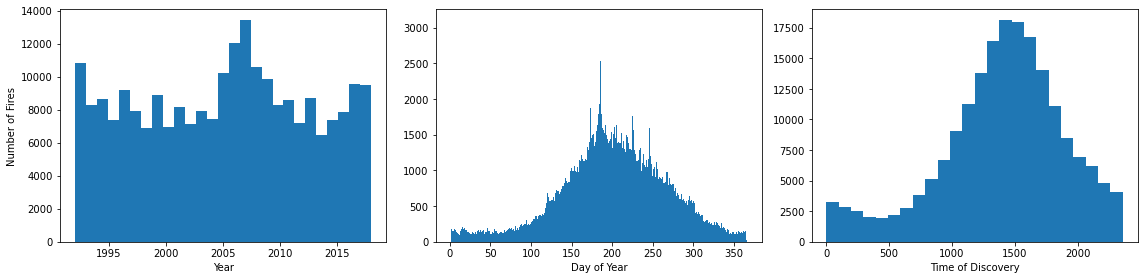

In [17]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.hist(fires.FIRE_YEAR, bins=fires.FIRE_YEAR.unique().shape[0])
plt.xlabel('Year')
plt.ylabel('Number of Fires')

plt.subplot(1, 3, 2)
plt.hist(fires.DISCOVERY_DOY, bins=fires.DISCOVERY_DOY.unique().shape[0])
plt.xlabel('Day of Year')

plt.subplot(1, 3, 3)
plt.hist(fires.DISCOVERY_TIME, bins=24)
plt.xlabel('Time of Discovery')

plt.tight_layout()
plt.show()

We can also see the cyclic pattern of the fires over the time scale of the dataset by adding the fraction (Day of Year / 365) to the year:

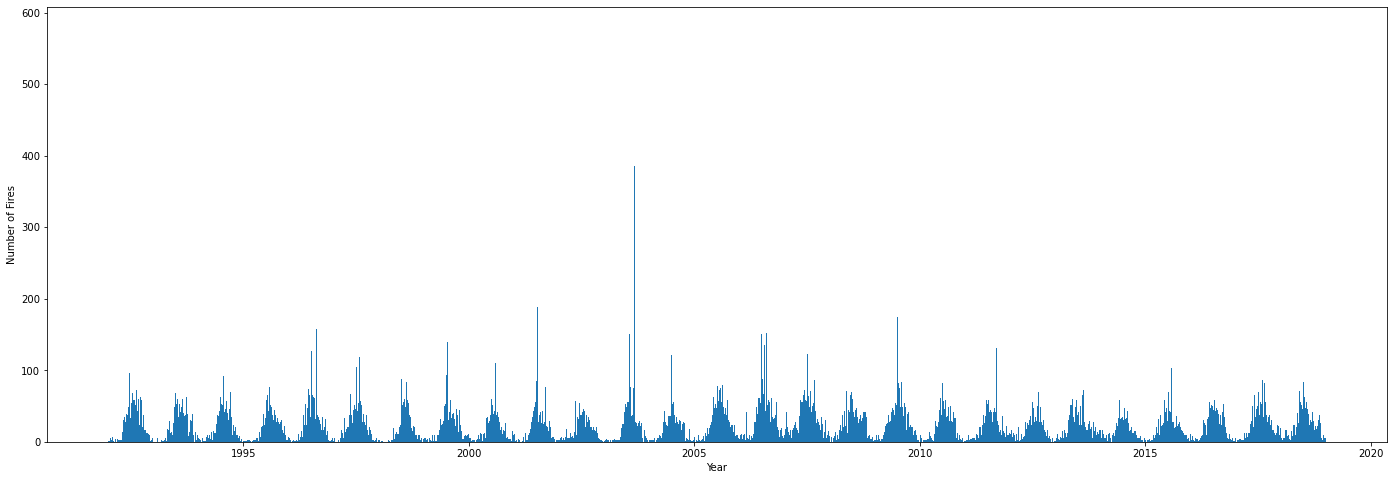

In [18]:
plt.figure(figsize=(24, 8))
plt.hist(fires.FIRE_YEAR + fires.DISCOVERY_DOY / 365, bins=365*fires.FIRE_YEAR.unique().shape[0])
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.show()

The next set of plots show the different causes of wildfires in California:

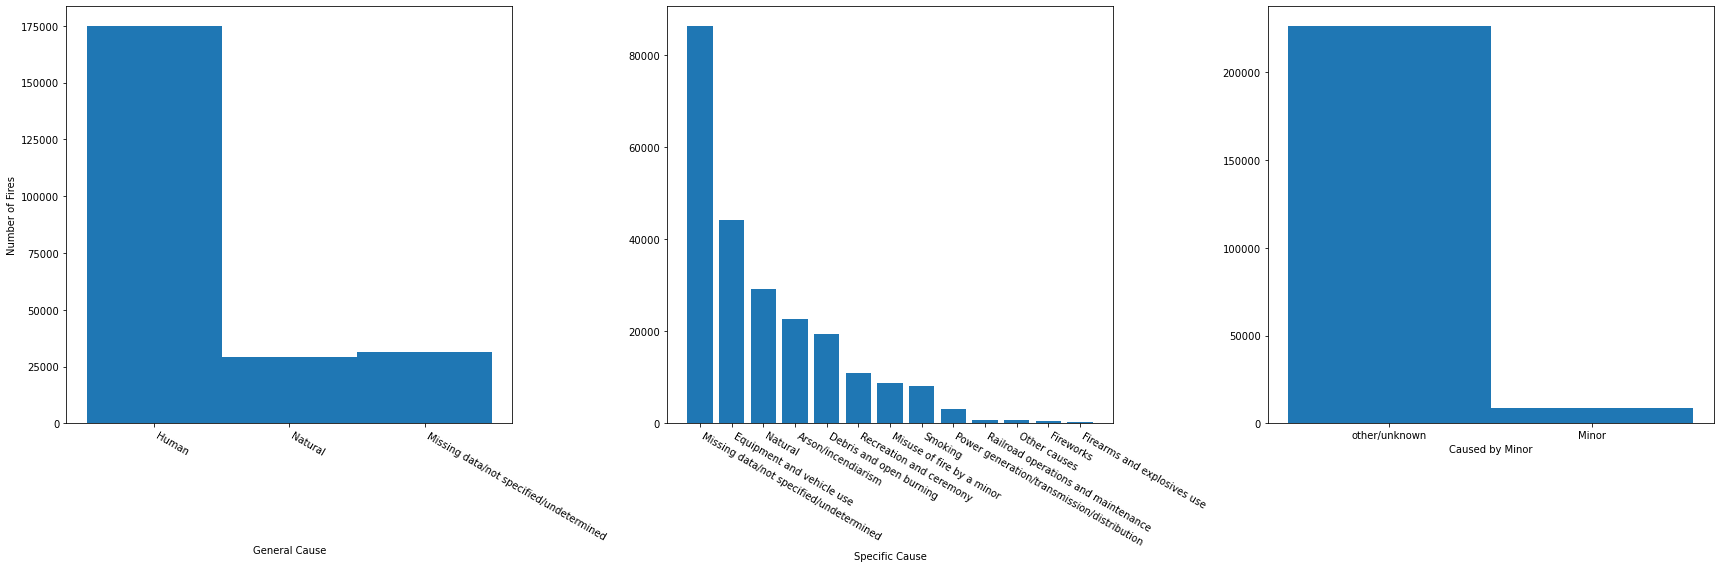

In [19]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.hist(fires.NWCG_CAUSE_CLASSIFICATION, bins=np.arange(1+fires.NWCG_CAUSE_CLASSIFICATION.unique().shape[0])-0.5)
plt.xlabel('General Cause')
plt.ylabel('Number of Fires')
plt.xticks(rotation=-30, ha="left")

causes = fires.groupby(['NWCG_GENERAL_CAUSE'])['NWCG_GENERAL_CAUSE'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
sortedCauses = pd.DataFrame(causes)
plt.subplot(1, 3, 2)
plt.bar(sortedCauses.NWCG_GENERAL_CAUSE, sortedCauses.Count)
plt.xlabel('Specific Cause')
plt.xticks(rotation=-30, ha="left")

plt.subplot(1, 3, 3)
plt.hist(fires.NWCG_CAUSE_AGE_CATEGORY, bins=np.arange(3)-0.5)
plt.xlabel('Caused by Minor')

plt.tight_layout()
plt.show()

Fire size is more difficult to visualize, due to the huge range in sizes.\
The plot on the left shows a histogram of the fire sizes.\
The plot on the right shows a histogram of the log of the fire sizes.  Fire size varies by several order of magnitude.\
The mean fire size is shown by the red vertical line.  Most fires remain smaller than an acre before they are contained.

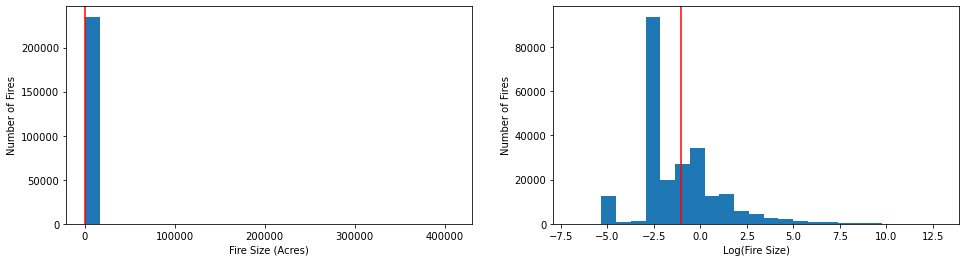

In [20]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.hist(fires.FIRE_SIZE, bins=25)
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Number of Fires')
plt.axvline(fires.FIRE_SIZE.mean(), color = 'r')

plt.subplot(1, 2, 2)
plt.hist(np.log(fires.FIRE_SIZE), bins=25)
plt.xlabel('Log(Fire Size)')
plt.ylabel('Number of Fires')
plt.axvline(np.log(fires.FIRE_SIZE).mean(), color = 'r')

plt.show()

We can also view the number of fires for each land owner group and each county:

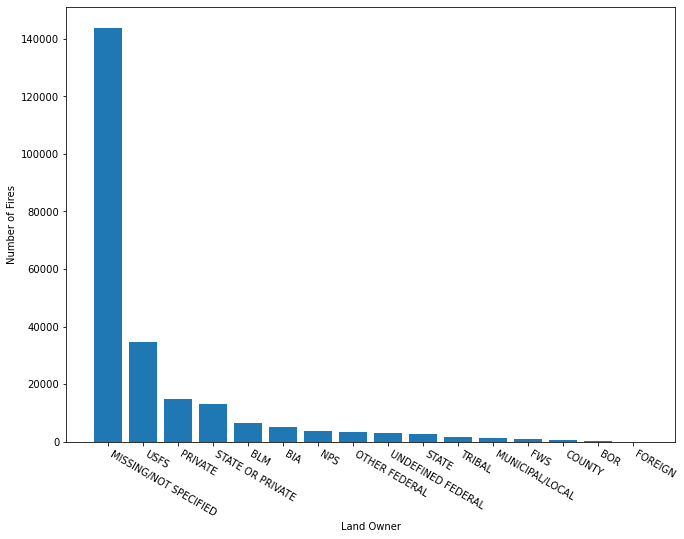

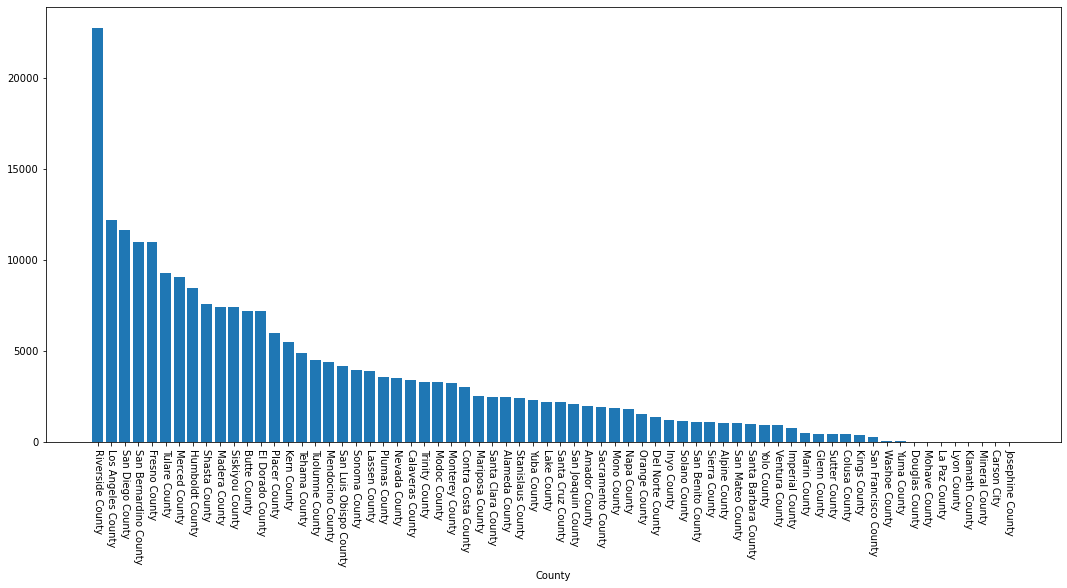

In [21]:
plt.figure(figsize=(24, 8))
owners = fires.groupby(['OWNER_DESCR'])['OWNER_DESCR'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
sortedOwners = pd.DataFrame(owners)
plt.subplot(1, 2, 1)
plt.bar(sortedOwners.OWNER_DESCR, sortedOwners.Count)
plt.xlabel('Land Owner')
plt.ylabel('Number of Fires')
plt.xticks(rotation=-30, ha="left")
plt.show()

plt.figure(figsize=(40, 8))
counties = fires.groupby(['FIPS_NAME'])['FIPS_NAME'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
sortedCounties = pd.DataFrame(counties)
plt.subplot(1, 2, 2)
plt.bar(sortedCounties.FIPS_NAME, sortedCounties.Count)
plt.xlabel('County')
plt.xticks(rotation=-90, ha="center")
plt.show()

Plotting the latitude and longitude shows the overall distribution of the fires:

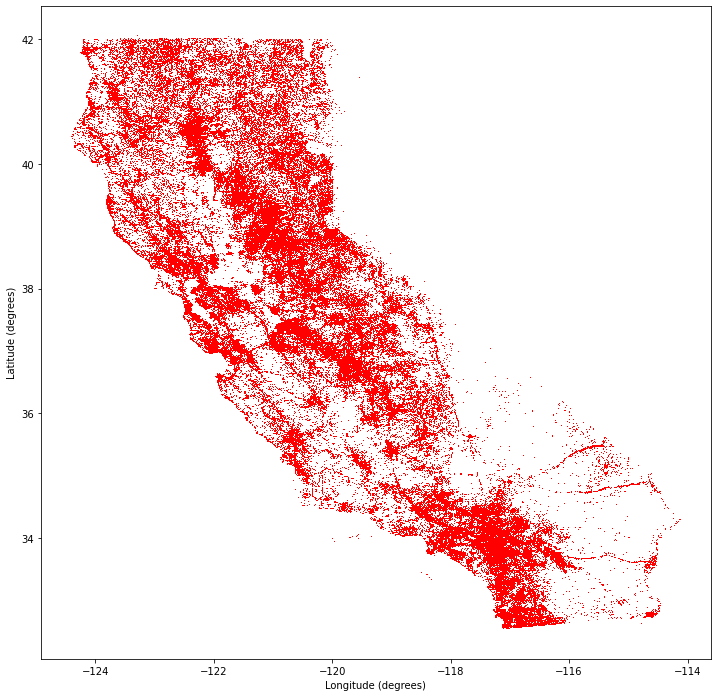

In [22]:
plt.figure(figsize=(12, 12))
plt.plot(fires.LONGITUDE, fires.LATITUDE, 'r,')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

The plots below show fire size plotted against each of the time-based features in the table, as well as the log of the fire size on the right:

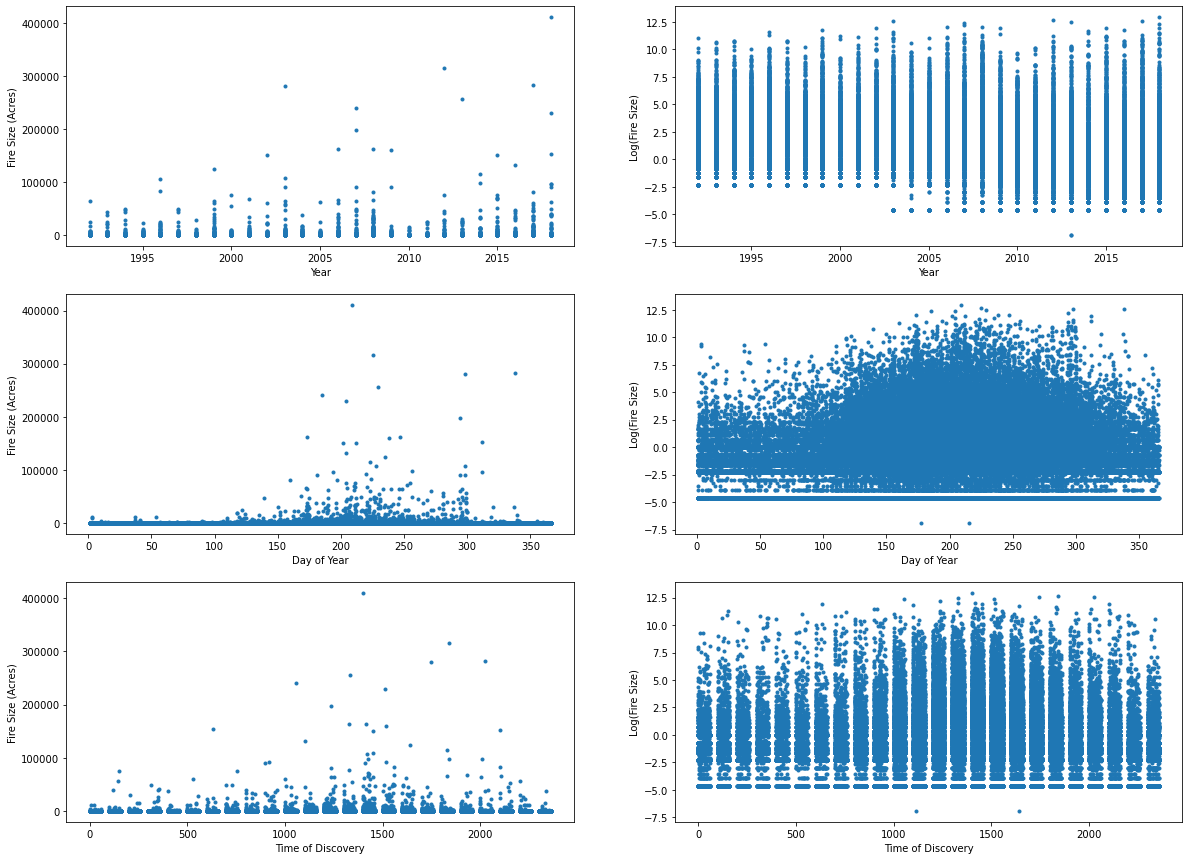

In [23]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
plt.plot(fires.FIRE_YEAR, fires.FIRE_SIZE, '.')
plt.xlabel('Year')
plt.ylabel('Fire Size (Acres)')

plt.subplot(3, 2, 2)
plt.plot(fires.FIRE_YEAR, np.log(fires.FIRE_SIZE), '.')
plt.xlabel('Year')
plt.ylabel('Log(Fire Size)')

plt.subplot(3, 2, 3)
plt.plot(fires.DISCOVERY_DOY, fires.FIRE_SIZE, '.')
plt.xlabel('Day of Year')
plt.ylabel('Fire Size (Acres)')

plt.subplot(3, 2, 4)
plt.plot(fires.DISCOVERY_DOY, np.log(fires.FIRE_SIZE), '.')
plt.xlabel('Day of Year')
plt.ylabel('Log(Fire Size)')

plt.subplot(3, 2, 5)
plt.plot(fires.DISCOVERY_TIME, fires.FIRE_SIZE, '.')
plt.xlabel('Time of Discovery')
plt.ylabel('Fire Size (Acres)')

plt.subplot(3, 2, 6)
plt.plot(fires.DISCOVERY_TIME, np.log(fires.FIRE_SIZE), '.')
plt.xlabel('Time of Discovery')
plt.ylabel('Log(Fire Size)')

plt.show()

We will need the log of the fire sizes, so it will be added to the fires dataframe:

In [24]:
fires['LOG_FIRE_SIZE'] = np.log(fires.FIRE_SIZE)

# Predicting Fire Size

First, let's split the data into a training dataset and a test dataset with a 80/20% split:

In [25]:
training_fires, test_fires = train_test_split(fires, test_size=0.2)

In [26]:
training_fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,NWCG_CAUSE_AGE_CATEGORY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME,LOG_FIRE_SIZE
168328,2013,12/27/2013 0:00,361,2125.0,Human,Arson/incendiarism,other/unknown,0.10,37.877150,-120.298567,UNDEFINED FEDERAL,Tuolumne County,-2.302585
24687,2000,6/16/2000 0:00,168,150.0,Human,Other causes,other/unknown,0.50,33.733889,-116.701667,STATE OR PRIVATE,Riverside County,-0.693147
176227,2015,9/7/2015 0:00,250,1614.0,Human,Missing data/not specified/undetermined,other/unknown,2.00,35.488100,-119.050800,PRIVATE,Kern County,0.693147
70216,1993,6/7/1993 0:00,158,NaN,Human,Equipment and vehicle use,other/unknown,1.00,36.071944,-120.208056,MISSING/NOT SPECIFIED,Fresno County,0.000000
159699,2012,9/27/2012 0:00,271,1650.0,Human,Missing data/not specified/undetermined,other/unknown,1.00,35.468545,-120.378849,MISSING/NOT SPECIFIED,San Luis Obispo County,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37459,1993,5/1/1993 0:00,121,1241.0,Human,Arson/incendiarism,other/unknown,70.00,34.700000,-117.134200,PRIVATE,San Bernardino County,4.248495
195202,2016,7/9/2016 0:00,191,1710.0,Human,Missing data/not specified/undetermined,other/unknown,0.10,35.731552,-120.889837,MISSING/NOT SPECIFIED,San Luis Obispo County,-2.302585
193347,2016,1/29/2016 0:00,29,1123.0,Human,Smoking,other/unknown,0.11,34.133333,-118.616666,MISSING/NOT SPECIFIED,Los Angeles County,-2.207275
26095,2001,3/18/2001 0:00,77,45.0,Human,Recreation and ceremony,other/unknown,0.10,40.751389,-121.500833,USFS,Shasta County,-2.302585


In [27]:
test_fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,NWCG_CAUSE_AGE_CATEGORY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_DESCR,FIPS_NAME,LOG_FIRE_SIZE
76403,2008,8/30/2008 0:00,243,2112.0,Human,Missing data/not specified/undetermined,other/unknown,1.0,37.616944,-120.230000,MISSING/NOT SPECIFIED,Mariposa County,0.000000
169725,2014,8/31/2014 0:00,243,2108.0,Human,Equipment and vehicle use,other/unknown,0.1,36.748889,-119.065278,USFS,Fresno County,-2.302585
106161,2005,4/15/2005 0:00,105,1906.0,Human,Missing data/not specified/undetermined,other/unknown,0.1,39.371111,-121.678889,MISSING/NOT SPECIFIED,Butte County,-2.302585
71098,1995,9/10/1995 0:00,253,NaN,Human,Arson/incendiarism,other/unknown,5.0,37.016111,-119.393056,MISSING/NOT SPECIFIED,Fresno County,1.609438
191,2005,7/21/2005 0:00,202,1930.0,Natural,Natural,other/unknown,0.1,37.651944,-119.051389,USFS,Mono County,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32158,2004,7/13/2004 0:00,195,900.0,Human,Recreation and ceremony,other/unknown,0.1,41.418333,-121.895000,STATE OR PRIVATE,Siskiyou County,-2.302585
188627,2010,7/21/2010 0:00,202,1041.0,Human,Missing data/not specified/undetermined,other/unknown,0.1,38.967788,-122.596591,STATE OR PRIVATE,Lake County,-2.302585
143271,2010,4/30/2010 0:00,120,1413.0,Human,Missing data/not specified/undetermined,other/unknown,0.8,33.123056,-116.882500,USFS,San Diego County,-0.223144
111205,1997,5/11/1997 0:00,131,NaN,Human,Debris and open burning,other/unknown,0.1,40.373056,-120.615000,MISSING/NOT SPECIFIED,Lassen County,-2.302585


The simplest approach is to model fire size as a function of the year using linear regression:

In [28]:
model = smf.ols('FIRE_SIZE ~ FIRE_YEAR', training_fires).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FIRE_SIZE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     22.83
Date:                Tue, 09 Aug 2022   Prob (F-statistic):           1.77e-06
Time:                        03:46:22   Log-Likelihood:            -1.7277e+06
No. Observations:              188183   AIC:                         3.455e+06
Df Residuals:                  188181   BIC:                         3.455e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6644.8779   1405.601     -4.727      0.000   -9399.822   -3889.934
FIRE_YEAR      3.3492      0.701      4.778      0.000       1.975       4.723
==============================================================================
Omnibus:                   722424.027   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     948917675934.780
Skew:                          90.071   Prob(JB):                         0.00
Kurtosis:                   11002.462   Cond. No.                     5.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Clearly, the year itself is not a good predictor of fire size (R^2 = 0.000).

We can also try the log of the fire size:

In [ ]:
model = smf.ols('LOG_FIRE_SIZE ~ FIRE_YEAR', training_fires).fit()
model.summary()

\
\
\
This is essentially the same result.  The incidence of wildfires in California as a whole cannot be said to be increasing over time.
However, if we add the cause of the fire as a predictor, we get a different story: